/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


[x0, x1, x2]
2D_Cutting_Stock:
MINIMIZE
-25*x0 + -21*x1 + -10*x2 + 82
SUBJECT TO
Demand_for_5x5_rectangles: x0 = 1

Demand_for_7x3_rectangles: x1 = 1

Demand_for_5x2_rectangles: x2 = 1

VARIABLES
0 <= x0 Integer
0 <= x1 Integer
0 <= x2 Integer

Status: Optimal
x0 = 1.0
x1 = 1.0
x2 = 1.0
Total waste area: 26.0
current length and width
5 5

Current jk: 0 0
40
Current jk: 0 1
35
Current jk: 0 2
30
Current jk: 0 3
25
Current jk: 0 4
20
Current jk: 0 5
15
Current jk: 1 0
35
Current jk: 1 1
30
Current jk: 1 2
25
Current jk: 1 3
20
Current jk: 1 4
15
Current jk: 1 5
10
Current jk: 2 0
30
Current jk: 2 1
25
Current jk: 2 2
20
Current jk: 2 3
15
Current jk: 2 4
10
Current jk: 2 5
5
Current jk: 3 0
25
Current jk: 3 1
20
Current jk: 3 2
15
Current jk: 3 3
10
Current jk: 3 4
5
Current jk: 3 5
0
Current jk: 0 0
40
Current jk: 0 1
35
Current jk: 0 2
30
Current jk: 0 3
25
Current jk: 0 4
20
Current jk: 0 5
15
Current jk: 1 0
35
Current jk: 1 1
30
Current jk: 1 2
25
Current jk: 1 3
20
Current jk: 1 4


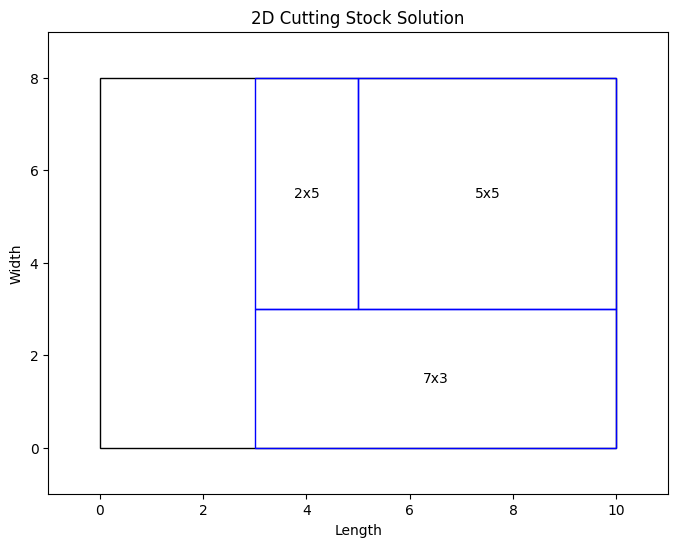

In [ ]:

from pulp import LpProblem, LpMinimize, LpInteger, LpVariable, value, LpStatus
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Problem data
board_length = 10
board_width = 8
rectangles = [(5, 5), (5,2), (7, 3)]
rectangle_demands = [1, 1, 1]

# Create a list of tuples with (length, width, demand)
rectangle_tuples = list(zip(rectangles, rectangle_demands))

# Sort the tuples based on the rectangle area (length * width)
sorted_tuples = sorted(enumerate(rectangle_tuples), key=lambda x: x[1][0][0] * x[1][0][1], reverse=True)

# Extract the sorted dimensions and demands, and the original indices
sorted_rectangles = [tup[1][0] for tup in sorted_tuples]
sorted_demands = [tup[1][1] for tup in sorted_tuples]
original_indices = [tup[0] for tup in sorted_tuples]

# Create the problem
problem = LpProblem("2D Cutting Stock", LpMinimize)

# Decision variables
variables = [LpVariable(f"x{i}", lowBound=0, cat=LpInteger) for i in range(len(sorted_rectangles))]
print(variables)

# Objective function
waste_area = board_length * board_width - sum(length * width * variables[i] for i, (length, width) in enumerate(sorted_rectangles))
# Minimize the difference between length and width of the remaining waste
waste_diff = abs(board_length - board_width)
problem += waste_area + waste_diff

# Demand constraints
for i, demand in enumerate(sorted_demands):
    length, width = sorted_rectangles[i]
    problem += variables[i] == demand, f"Demand for {length}x{width} rectangles"
print(problem)

# Solve the problem
problem.solve()

# Get the status of the solution
print("Status:", LpStatus[problem.status])

# Print the optimal solution
for var in problem.variables():
    print(var.name, "=", var.varValue)

# Print the optimal objective value
print("Total waste area:", value(problem.objective))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Draw the board
board_rect = patches.Rectangle((0, 0), board_length, board_width, linewidth=1, edgecolor='black', facecolor='none')
ax.add_patch(board_rect)

# Draw the cut rectangles using the best-fit heuristic
placed_rectangles = []

for i, var in enumerate(variables):
    length, width = sorted_rectangles[i]
    print('current length and width')
    print(length, width)
    print()
    for _ in range(int(value(var))):
        # Initialize minimum waste and best position variables
        min_waste = float('inf')
        best_x, best_y = None, None
        best_orientation = None

        # Iterate over both orientations (original and reverse)
        for orientation in [(length, width), (width, length)]:
            length_oriented, width_oriented = orientation

            # Iterate over possible starting positions
            for j in range(board_width - width_oriented + 1):
                for k in range(board_length - length_oriented + 1):
                    print("Current jk:", j, k)

                    waste = 0
                    available = True
                    for rect in placed_rectangles:
                        if (rect[0] < k + length_oriented and rect[0] + rect[2] > k and
                                rect[1] < j + width_oriented and rect[1] + rect[3] > j):
                            available = False
                            break
                    if available:
                        waste = (board_length - j - length_oriented) * (board_width - k) + j * (
                                    board_width - k - width_oriented)
                        print(waste)
                        if waste < min_waste:
                            min_waste = waste
                            best_x, best_y = k, j
                            best_orientation = orientation

        # Draw the rectangle at the best position
        rect = patches.Rectangle((best_x, best_y), best_orientation[0], best_orientation[1], linewidth=1,
                                 edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        placed_rectangles.append((best_x, best_y, best_orientation[0], best_orientation[1]))
        print(placed_rectangles)
        print()

        # Annotate the rectangle with its dimensions
        ax.text(best_x + best_orientation[0] / 2, best_y + best_orientation[1] / 2,
                f"{best_orientation[0]}x{best_orientation[1]}", ha='center', va='center')

# Set axis limits and labels
ax.set_xlim([-1, board_length + 1])
ax.set_ylim([-1, board_width + 1])
ax.set_xlabel('Length')
ax.set_ylabel('Width')
ax.set_title('2D Cutting Stock Solution')

# Show the plot
plt.show()